In [1]:
# import required libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
import keras
from keras.layers.core import Activation
import keras.backend as K
from keras.layers import Dense , LSTM, Dropout
from keras.models import Sequential, load_model
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import math
import xgboost
import time
from tqdm import tqdm

In [2]:
data_path="CMaps/"

In [3]:
fd_001_train=pd.read_csv("CMaps/train_FD001.txt",sep=" ",header=None)
fd_001_test=pd.read_csv("CMaps/test_FD001.txt",sep=" ",header=None)
RUL_fd_001=pd.read_csv("CMaps/RUL_FD001.txt",sep=" ",header=None)

In [4]:
fd_001_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,0.0,0.0
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,NaN,NaN
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251,NaN,NaN
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,NaN,NaN
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,NaN,NaN
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,NaN,NaN
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,NaN,NaN
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,NaN,NaN


In [5]:
fd_001_train.drop(columns=[26,27],inplace=True)
fd_001_test.drop(columns=[26,27],inplace=True)

In [6]:
# columns=['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
#            'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]
columns=['unit_number','time_in_cycles','setting_1','setting_2','TRA','FanInTemp','LPCompOT','HPCompOT','LPTurbineOT','FanInP','BypassDuctP','HPCompOP','PhyFanSpeed','PhyCoreSpeed',
         'EngPreRatio','HPCOStaticPre','RFuelFlow','CorrectedFanSpeed','CorrectedCoreSpeed','BypassRatio','BurnerFuelAirRatio','BleedEnthalpy','ReqFanSpeed','ReqFanConvSpeed','HPTurbineCoolAirFlow','LPTurbineAirFlow']
fd_001_train.columns = columns
fd_001_test.columns=columns

In [7]:
fd_001_train.describe

<bound method NDFrame.describe of        unit_number  time_in_cycles  setting_1  setting_2    TRA  FanInTemp  \
0                1               1    -0.0007    -0.0004  100.0     518.67   
1                1               2     0.0019    -0.0003  100.0     518.67   
2                1               3    -0.0043     0.0003  100.0     518.67   
3                1               4     0.0007     0.0000  100.0     518.67   
4                1               5    -0.0019    -0.0002  100.0     518.67   
...            ...             ...        ...        ...    ...        ...   
20626          100             196    -0.0004    -0.0003  100.0     518.67   
20627          100             197    -0.0016    -0.0005  100.0     518.67   
20628          100             198     0.0004     0.0000  100.0     518.67   
20629          100             199    -0.0011     0.0003  100.0     518.67   
20630          100             200    -0.0032    -0.0005  100.0     518.67   

       LPCompOT  HPCompOT  LP

In [8]:
#delete columns with constant values ​​that do not carry information about the state of the unit
drop_columns=['ReqFanSpeed','ReqFanConvSpeed','FanInP','FanInTemp','TRA','BurnerFuelAirRatio','EngPreRatio']
fd_001_train.drop(columns=drop_columns,inplace=True)
#fd_001_train.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)


## We will display the mutual correlations of the signs on the "heat map", for this we will prepare an additional sign "RUL", showing the number of cycles to failure in the training data

In [9]:
#function for preparing training data and forming a RUL column with information about the remaining
# before breaking cycles
def add_rul_column(data, factor = 0):
    df = data.copy()
    fd_RUL = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
    fd_RUL = pd.DataFrame(fd_RUL)
    fd_RUL.columns = ['unit_number','max']
    df = df.merge(fd_RUL, on=['unit_number'], how='left')
    df['RUL'] = df['max'] - df['time_in_cycles']
    df.drop(columns=['max'],inplace = True)


    return df[df['time_in_cycles'] > factor]

In [10]:
df=add_rul_column(fd_001_train)

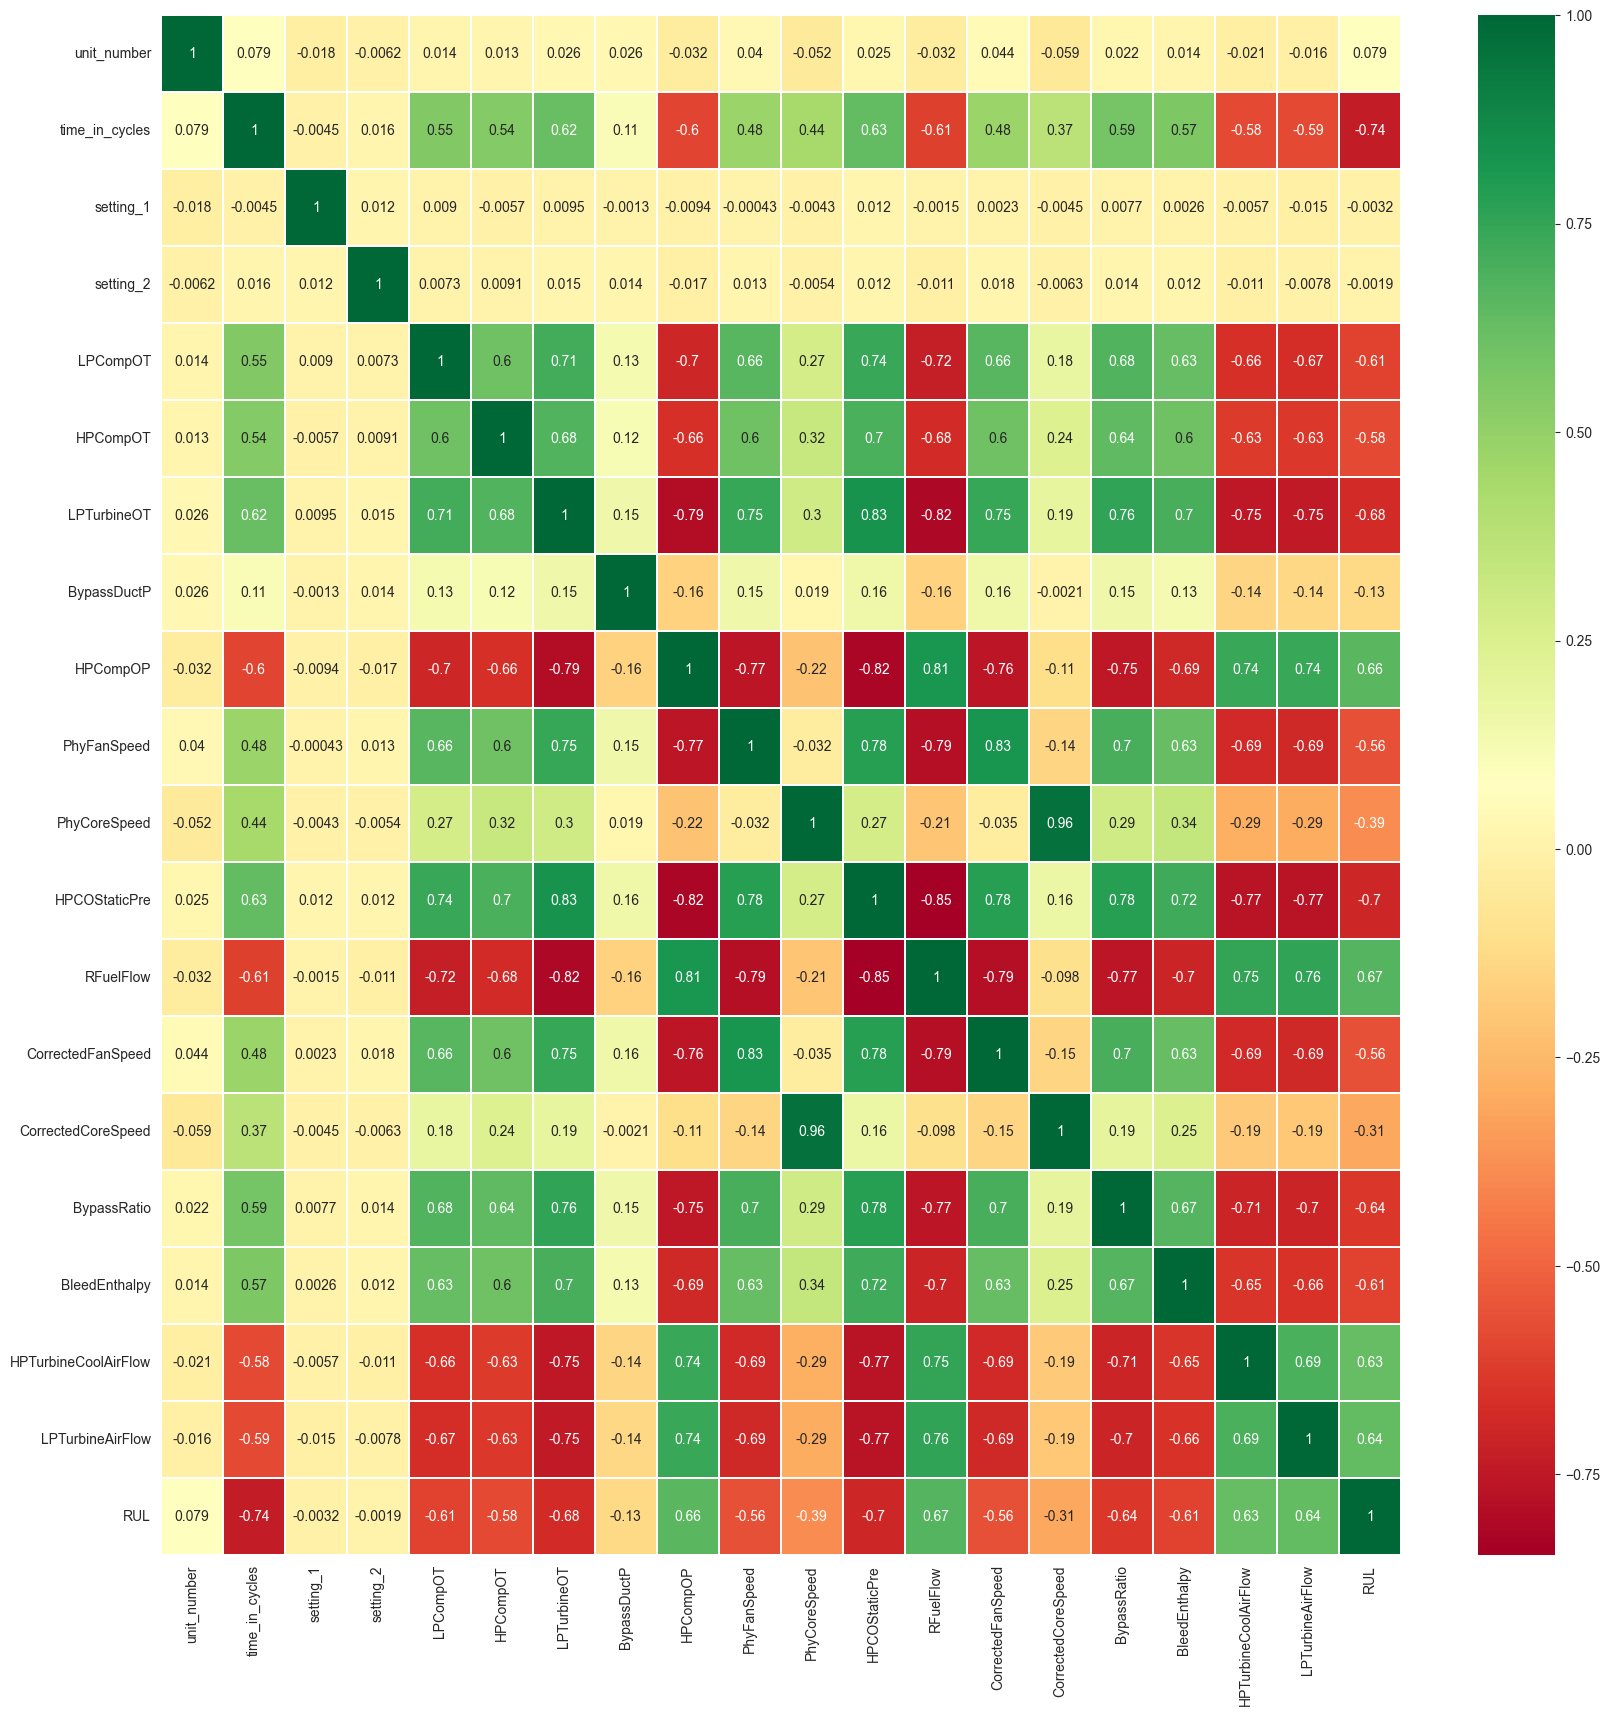

In [11]:
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

## Error Function for Competitive Data

In [12]:
#Error Function for Competitive Data
def score(y_true,y_pred,a1=10,a2=13):
    score = 0
    d = y_pred - y_true
    for i in d:
        if i >= 0 :
            score += math.exp(i/a2) - 1
        else:
            score += math.exp(- i/a1) - 1
    return score

In [13]:
def score_func(y_true,y_pred):
    lst = [round(score(y_true,y_pred),2),
          round(mean_absolute_error(y_true,y_pred),2),
          round(mean_squared_error(y_true,y_pred),2)**0.5,
          round(r2_score(y_true,y_pred),2)]

    print(f' compatitive score {lst[0]}')
    print(f' mean absolute error {lst[1]}')
    print(f' root mean squared error {lst[2]}')
    print(f' R2 score {lst[3]}')
    return [lst[1], round(lst[2],2), lst[3]*100]

## We remove the properties that weakly correlate with the RUL target: setting_1, setting_2, P15, unit_number, as well as one of the features that are highly correlated with each other (Nc and NRc have a correlation coefficient of 0.96, remove NRc)

In [14]:
unit_number = pd.DataFrame(df["unit_number"])
train_df = df.drop(columns = ['unit_number','setting_1','setting_2','BypassDuctP','CorrectedCoreSpeed'])
unit_number

,unit_number
0,1
1,1
2,1
3,1
4,1
...,...
20626,100
20627,100
20628,100
20629,100


In [15]:
train_df.head()

,time_in_cycles,LPCompOT,HPCompOT,LPTurbineOT,HPCompOP,PhyFanSpeed,PhyCoreSpeed,HPCOStaticPre,RFuelFlow,CorrectedFanSpeed,BypassRatio,BleedEnthalpy,HPTurbineCoolAirFlow,LPTurbineAirFlow,RUL
0,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187


IMPLEMENTING LSTM

Prepare Data For LSTM

In [16]:
train_df_lstm=pd.concat([unit_number,train_df],axis=1)
RUL=pd.read_csv('CMaps/RUL_FD001.txt',sep=" ",header=None)
fd_001_test.drop(columns=drop_columns,inplace=True)
test_max=fd_001_test.groupby('unit_number')['time_in_cycles'].max().reset_index()
test_max.columns=['unit_number','max']
fd_001_test=fd_001_test.merge(test_max,on=['unit_number'],how='left')

In [17]:
fd_001_test

,unit_number,time_in_cycles,setting_1,setting_2,LPCompOT,HPCompOT,LPTurbineOT,BypassDuctP,HPCompOP,PhyFanSpeed,PhyCoreSpeed,HPCOStaticPre,RFuelFlow,CorrectedFanSpeed,CorrectedCoreSpeed,BypassRatio,BleedEnthalpy,HPTurbineCoolAirFlow,LPTurbineAirFlow,max
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,21.61,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,31
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,21.61,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,31
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,21.61,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,31
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,21.61,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,31
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,21.61,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,643.24,1599.45,1415.79,21.61,553.41,2388.02,9142.37,47.69,520.69,2388.00,8213.28,8.4715,394,38.65,23.1974,198
13092,100,195,-0.0011,-0.0001,643.22,1595.69,1422.05,21.61,553.22,2388.05,9140.68,47.60,521.05,2388.09,8210.85,8.4512,395,38.57,23.2771,198
13093,100,196,-0.0006,-0.0003,643.44,1593.15,1406.82,21.61,553.04,2388.11,9146.81,47.57,521.18,2388.04,8217.24,8.4569,395,38.62,23.2051,198
13094,100,197,-0.0038,0.0001,643.26,1594.99,1419.36,21.61,553.37,2388.07,9148.85,47.61,521.33,2388.08,8220.48,8.4711,395,38.66,23.2699,198


In [18]:
non_scale_cols=['unit_number','time_in_cycles','RUL','label1','label2']

In [19]:
def scale_data(train_df,test_df):
    train_df['cycle_norm']=train_df['time_in_cycles']
    cols_normalize=train_df.columns.difference(non_scale_cols)
    standard_scaler=StandardScaler()
    # print(f"train_df >> {train_df.head()}")
    # print("\n")
    scaled_train_df=pd.DataFrame(standard_scaler.fit_transform(train_df[cols_normalize]),columns=cols_normalize,index=train_df.index)
    join_df=train_df[train_df.columns.difference(cols_normalize)].join(scaled_train_df)
    train_df=join_df.reindex(columns=train_df.columns)
    print(f"train_df >> {train_df.head()}")
    print("\n")

    test_df=test_df.drop(columns=['setting_1','setting_2','BypassDuctP','CorrectedCoreSpeed','max'])
    test_df['cycle_norm'] = test_df['time_in_cycles']
    norm_test_df = pd.DataFrame(standard_scaler.transform(test_df[cols_normalize]),
                                columns=cols_normalize,
                                index=test_df.index)
    test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
    test_df = test_join_df.reindex(columns = test_df.columns)
    test_df = test_df.reset_index(drop=True)


    return train_df,test_df


In [20]:
def add_rul_column_for_test(test_df,truth_df):
    rul = pd.DataFrame(test_df.groupby('unit_number')['time_in_cycles'].max()).reset_index()
    rul.columns = ['unit_number','max']

    truth_df.drop(truth_df.columns[1],axis=1,inplace=True)

    rul = pd.DataFrame(test_df.groupby('unit_number')['time_in_cycles'].max()).reset_index()
    rul.columns = ['unit_number','max']
    truth_df.columns = ['more']
    truth_df['unit_number'] = truth_df.index + 1
    truth_df['max'] = rul['max'] + truth_df['more'] # adding true-rul vlaue + max cycle of test data set w.r.t MID
    truth_df.drop('more', axis=1, inplace=True)

    # generate RUL for test data
    test_df = test_df.merge(truth_df, on=['unit_number'], how='left')
    test_df['RUL'] = test_df['max'] - test_df['time_in_cycles']
    test_df.drop('max', axis=1, inplace=True)

    # generate label columns w0 and w1 for test data
    test_df=convert_rul_to_label(test_df)
    print(f"test_df >> {test_df.head()} \n")


    return test_df,truth_df

train_df_lstm, fd_001_test, RUL.copy()

In [21]:
def gen_sequence(id_df,seq_length,seq_cols):
    data_matrix=id_df[seq_cols].values
    num_elements=data_matrix.shape[0]
    for start,stop in zip(range(0,num_elements-seq_length),range(seq_length,num_elements)):
        yield data_matrix[start:stop,:]

In [22]:
def gen_labels(id_df,seq_length,label):
    data_matrix=id_df[label].values
    num_elements=data_matrix.shape[0]
    return data_matrix[seq_length:num_elements,:]

In [23]:
# we will only make use of "label1" for binary classification,
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
def convert_rul_to_label(df,w1=30,w0=15):
    df['label1'] = np.where(df['RUL'] <= w1, 1, 0 )
    df['label2'] = df['label1']
    df.loc[df['RUL'] <= w0, 'label2'] = 2
    return df

In [ ]:
def lstm_data_preprocessing(raw_train_data,fd_001_test,raw_RUL_data):
    train_df=raw_train_data
    truth_df=raw_RUL_data
    test_df=fd_001_test

    train_df=convert_rul_to_label(train_df)

    train_df,test_df=scale_data(train_df,test_df)

    # We use the ground truth dataset to generate labels for the test data.
    # generate column max for test data
    test_df,truth_df=add_rul_column_for_test(test_df,truth_df)


    sequence_length=50
    sequence_cols=list(test_df.columns[:-3])

    print(f"sequence_cols: {sequence_cols}")

    # TODO for debug
    # val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 25 columns)
    val=list(gen_sequence(train_df[train_df['unit_number']==1], sequence_length, sequence_cols))
    print(len(val))
    # generator for the sequences
    # transform each id of the train dataset in a sequence
    seq_gen = (list(gen_sequence(train_df[train_df['unit_number']==id], sequence_length, sequence_cols))
               for id in train_df['unit_number'].unique())
        # generate sequences and convert to numpy array
    seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    print(f"seq_array shape: {seq_array.shape}")


    # generate labels
    label_gen = [gen_labels(train_df[train_df['unit_number']==id], sequence_length, ['RUL'])
                 for id in train_df['unit_number'].unique()]

    label_array = np.concatenate(label_gen).astype(np.float32)
    print(label_array.shape)
    print(label_array[2])

    return seq_array, label_array, test_df, sequence_length, sequence_cols


In [ ]:
seq_array, label_array, test_df, sequence_length, sequence_cols=lstm_data_preprocessing(train_df_lstm,fd_001_test,RUL.copy())

In [26]:
label_array.shape

(15631, 1)

In [35]:
label_array[160]

array([218.], dtype=float32)

In [27]:
def r2_keras(y_true, y_pred):
    """Coefficient of Determination
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [28]:
def lstm_train(seq_array, label_array, sequence_length):
    # The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units.
    # Dropout is also applied after each LSTM layer to control overfitting.
    # Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.
    callback=keras.callbacks.EarlyStopping(monitor='loss',patience=4)
    nb_features = seq_array.shape[2]
    nb_out = label_array.shape[1]

    model = Sequential()
    model.add(LSTM(
             input_shape=(sequence_length, nb_features),
             units=100,
             return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(
              units=50,
              return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=nb_out))
    model.add(Activation("relu"))
    model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

    print(model.summary())

    # fit the network # Commoly used 100 epoches but 50-60 are fine its an early cutoff
    history = model.fit(seq_array, label_array, epochs=150, batch_size=128, validation_split=0.05, verbose=2,callbacks=[callback])
    #           callbacks = [keras.callbacks.EarlyStoping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
    #                        keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
    #           )

    # list all data in history
    print(history.history.keys())

    return model, history

In [29]:
def lstm_test_evaluation_graphs(model, history, seq_array, label_array):
    # summarize history for R^2
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['r2_keras'])
    plt.plot(history.history['val_r2_keras'])
    plt.title('model r^2')
    plt.ylabel('R^2')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # fig_acc.savefig("model_r2.png")

    # summarize history for MAE
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('model MAE')
    plt.ylabel('MAE')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # fig_acc.savefig("model_mae.png")

    # summarize history for Loss
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # fig_acc.savefig("model_regression_loss.png")

    # training metrics
    scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
    print('\nMAE: {}'.format(scores[1]))
    print('\nR^2: {}'.format(scores[2]))

    y_pred = model.predict(seq_array,verbose=1, batch_size=200)
    y_true = label_array

    test_set = pd.DataFrame(y_pred )
    test_set.head()
    # test_set.to_csv('submit_train.csv', index = None)

In [30]:
def lstm_valid_evaluation(lstm_test_df, model, sequence_length, sequence_cols):
    # We pick the last sequence for each id in the test data
    seq_array_test_last = [lstm_test_df[lstm_test_df['unit_number']==id][sequence_cols].values[-sequence_length:]
                           for id in lstm_test_df['unit_number'].unique() if len(lstm_test_df[lstm_test_df['unit_number']==id]) >= sequence_length]

    seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

    # Similarly, we pick the labels
    y_mask = [len(lstm_test_df[lstm_test_df['unit_number']==id]) >= sequence_length for id in lstm_test_df['unit_number'].unique()]
    label_array_test_last = lstm_test_df.groupby('unit_number')['RUL'].nth(-1)[y_mask].values
    label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

    estimator = model

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    print(test_set.head())

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred_test)
    plt.plot(y_true_test, color="orange")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    # fig_verify.savefig("model_regression_verify.png")
    return scores_test[1], scores_test[2]

In [31]:
seq_array

array([[[ 1.0000000e+00,  1.0000000e+00, -1.7217253e+00, ...,
          1.3484927e+00,  1.1944270e+00, -1.5651702e+00],
        [ 1.0000000e+00,  2.0000000e+00, -1.0617797e+00, ...,
          1.0165279e+00,  1.2369219e+00, -1.5506520e+00],
        [ 1.0000000e+00,  3.0000000e+00, -6.6181260e-01, ...,
          7.3989058e-01,  5.0342280e-01, -1.5361339e+00],
        ...,
        [ 1.0000000e+00,  4.8000000e+01, -1.5817369e+00, ...,
          6.8456310e-01,  6.9557375e-01, -8.8281739e-01],
        [ 1.0000000e+00,  4.9000000e+01, -9.0179288e-01, ...,
          1.3484927e+00,  1.4789582e+00, -8.6829925e-01],
        [ 1.0000000e+00,  5.0000000e+01,  1.7811824e-01, ...,
          1.8661590e-01,  1.1168276e+00, -8.5378110e-01]],

       [[ 1.0000000e+00,  2.0000000e+00, -1.0617797e+00, ...,
          1.0165279e+00,  1.2369219e+00, -1.5506520e+00],
        [ 1.0000000e+00,  3.0000000e+00, -6.6181260e-01, ...,
          7.3989058e-01,  5.0342280e-01, -1.5361339e+00],
        [ 1.0000000e+00, 

In [32]:
train_df.shape

(20631, 15)

In [33]:
model, history= lstm_train(seq_array,label_array,sequence_length)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           46800     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 77,051
Trainable params: 77,051
Non-traina

Exception ignored in: <function UniquePtr.__del__ at 0x00000255933D1C10>
Traceback (most recent call last):
  File "C:\Users\takyol\sktime_3.8\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 74, in __del__
    self.deleter(obj)
KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
lstm_test_evaluation_graphs(model, history, seq_array, label_array)

In [ ]:
MAE, R2 = lstm_valid_evaluation(test_df, model, sequence_length, sequence_cols)
# mae, rmse, r2
LSTM_individual_scorelst = [round(MAE,2), 0, round(R2,2)*100]

In [ ]:
RUL